Importing libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

Specyfing a time frame

In [2]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

Creating a list of tickers

In [3]:
tickers = ["SPY","BND","GLD","QQQ","VTI"]

Downloading the data

In [4]:
adj_close_df = pd.DataFrame()


for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data["Adj Close"]


print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-07-07   66.597748  50.444355   90.709999   30.172197   33.598640
2009-07-08   66.552368  50.789284   89.269997   30.329487   33.553062
2009-07-09   66.680931  50.639572   89.510002   30.381914   33.621449
2009-07-10   66.522141  50.821812   89.580002   30.512978   33.537880
2009-07-13   68.140587  50.737236   90.190002   31.098423   34.312862
...                ...        ...         ...         ...         ...
2024-06-26  545.510010  72.038361  212.580002  480.369995  267.780304
2024-06-27  546.369995  72.167953  214.990005  481.609985  268.428009
2024-06-28  544.219971  71.829002  215.009995  479.109985  267.510010
2024-07-01  545.340027  71.449997  215.570007  481.920013  268.049988
2024-07-02  549.010010  71.660004  215.559998  486.980011  269.600006

[3773 rows x 5 columns]


Calculating returns

In [5]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-07-08 -0.000682  0.006815 -0.016002  0.005200 -0.001357
2009-07-09  0.001930 -0.002952  0.002685  0.001727  0.002036
2009-07-10 -0.002384  0.003592  0.000782  0.004305 -0.002489
2009-07-13  0.024038 -0.001666  0.006786  0.019005  0.022845
2009-07-14  0.005644 -0.002955  0.006851  0.003646  0.007061
...              ...       ...       ...       ...       ...
2024-06-26  0.001247 -0.004694 -0.009271  0.002063 -0.000037
2024-06-27  0.001575  0.001797  0.011273  0.002578  0.002416
2024-06-28 -0.003943 -0.004708  0.000093 -0.005204 -0.003426
2024-07-01  0.002056 -0.005290  0.002601  0.005848  0.002016
2024-07-02  0.006707  0.002935 -0.000046  0.010445  0.005766

[3772 rows x 5 columns]


Creating functions for Monte Carlo simulation

In [6]:
def expected_return(weights, log_returns):  
    return np.sum(log_returns.mean()*weights)

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def random_z_score():
    return np.random.normal(0,1)

In [7]:
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.168616e-04 -1.715897e-07  0.000007  1.287155e-04  1.192974e-04
BND -1.715897e-07  9.207246e-06  0.000009  7.220027e-07  2.284519e-08
GLD  6.580431e-06  8.635269e-06  0.000097  7.444688e-06  7.168539e-06
QQQ  1.287155e-04  7.220027e-07  0.000007  1.646759e-04  1.315621e-04
VTI  1.192974e-04  2.284519e-08  0.000007  1.315621e-04  1.228302e-04


In [8]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))

portfolio_expected_return = expected_return(weights,log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

In [9]:
days = 5

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return*days+portfolio_value*portfolio_std_dev*z_score*np.sqrt(days)

Performing simulations, specyfinig number of days

In [10]:
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

Specyfing confidence interval, calculating VaR

In [11]:
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100*( 1-confidence_interval))
print(VaR)

34301.832395752666


Plotting the results 

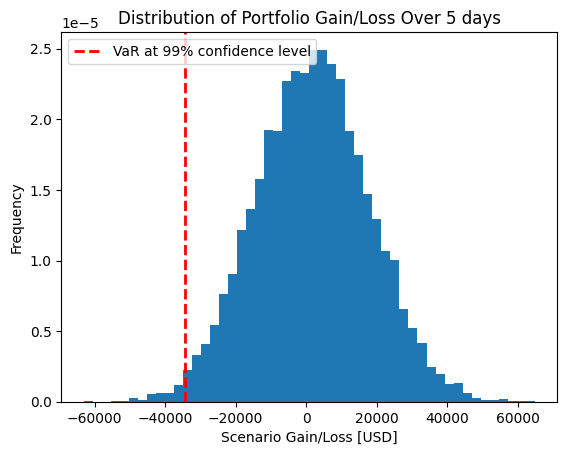

In [12]:
plt.hist(scenarioReturn, bins = 50, density=True)
plt.xlabel("Scenario Gain/Loss [USD]")
plt.ylabel("Frequency")
plt.title(f"Distribution of Portfolio Gain/Loss Over {days} days")
plt.axvline(-VaR, color = 'r', linestyle="dashed", linewidth=2, label = f"VaR at {confidence_interval:.0%} confidence level")
plt.legend()
plt.show()